This Project implements data of vaccination rates of all counties in the US, as of 11/18/2021

In [ ]:
# Load the data and libraries
import pandas as pd
import numpy as np
import decimal
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

# This is where the data we will work on is located
vaccination = pd.read_csv('https://raw.githubusercontent.com/joshbakervt/Differentially-Private-Vaccination-Statuses/main/Vaccination_Status_Processed.csv')

# The columns to use are:
# Date, Recip_County, Recip_State, Series_Complete_Pop_Pct, Series_Complete_Yes,
# Series_Complete_12PlusPop_Pct, Series_Complete_18PlusPop_Pct, Series_Complete_65PlusPop_Pct, Completeness_pct,
# Administered_Dose1_Pop_Pct, Administered_Dose1_Recip_12Plus

To start, we will format the data in the dataset to be operable. We will do this by creating an isolated list of all states, and completed percentages of their respective counties

In [ ]:
# Create a list of states:
def create_state_list(df):
  states_in_list = []
  for i in vaccination['Recip_State']:
    if i not in states_in_list:
      states_in_list.append(i)
  return states_in_list

# This number should be 59, as other US provinces and territories are included
print(len(create_state_list(vaccination)))

59


Down the line, we will want to have our data grouped based on region in the US. We will split these areas into West, Midwest, Northeast, and South

There are a total of 59 states and/or territories in the dataset, but we will focus on the 50 states on a US map.

In [ ]:
west = ['WA','MT','OR','ID','WY','CA','AK','NV','UT','CO','HI']
midwest = ['ND','MN','SD','NE','KS','IA','MO','IL','WI','IN','OH','MI']
northeast = ['PA','NY','NH','MA','ME','NJ','DE','CT','RI','VT']
south = ['AZ','NM','OK','TX','AR','LA','MS','MD','AL','TN','KY','WV','VA','NC','SC','GA','FL']

In [ ]:
def number_elements(state):
  return len(vaccination[(vaccination['Recip_State'] == state)]) - 1

In [ ]:
states_in_list = create_state_list(vaccination)

The following code runs a query for counties in each of the four regions, returning the statistical percentage of where counties lie, either under or over a vaccination completion rate of 50%

In [ ]:
def state_query_under(region):
  total = 0
  result = 0
  for states in region:
    total += len(vaccination[(vaccination['Recip_State'] == states)])
    result += len(vaccination[(vaccination['Recip_State'] == states) & (vaccination["Series_Complete_Pop_Pct"] <= 50)])
  final = (result/total)
  return round(final, 2)

def state_query_over(region):
  total = 0
  result = 0
  for states in region:
    total += len(vaccination[(vaccination['Recip_State'] == states)])
    result += len(vaccination[(vaccination['Recip_State'] == states) & (vaccination["Series_Complete_Pop_Pct"] > 50)])
  final = (result/total)
  return round(final, 2)

region_grouping = []
region_grouping.append(northeast)
region_grouping.append(south)
region_grouping.append(west)
region_grouping.append(midwest)
for b in region_grouping:
  print(b)
  print("Counties with Vaccination Rate Under 50:", str(state_query_under(b))+"%") 
  print("Counties with Vaccination Rate Over 50:", str(state_query_over(b))+"%\n") 
  # print(b,"percentage under half: %"+str((under/total_counties)*100))


['PA', 'NY', 'NH', 'MA', 'ME', 'NJ', 'DE', 'CT', 'RI', 'VT']
Counties with Vaccination Rate Under 50: 0.24%
Counties with Vaccination Rate Over 50: 0.76%

['AZ', 'NM', 'OK', 'TX', 'AR', 'LA', 'MS', 'MD', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL']
Counties with Vaccination Rate Under 50: 0.8%
Counties with Vaccination Rate Over 50: 0.2%

['WA', 'MT', 'OR', 'ID', 'WY', 'CA', 'AK', 'NV', 'UT', 'CO', 'HI']
Counties with Vaccination Rate Under 50: 0.56%
Counties with Vaccination Rate Over 50: 0.44%

['ND', 'MN', 'SD', 'NE', 'KS', 'IA', 'MO', 'IL', 'WI', 'IN', 'OH', 'MI']
Counties with Vaccination Rate Under 50: 0.65%
Counties with Vaccination Rate Over 50: 0.35%



Then, we add Laplace noise to the counting queries, ensuring differential privacy for  𝜖 = 1.0 .

In [ ]:
def dp_state_query_under(region, epsilon):
  result = state_query_under(region)
  return laplace_mech(result, 1, epsilon)

def dp_state_query_over(region, epsilon):
  result = state_query_over(region)
  return laplace_mech(result, 1, epsilon)

In [ ]:
for b in region_grouping:
  print(b)
  print("Counties with Differentially Private Vaccination Rate Under 50:", str(dp_state_query_under(b, 1))+"%") 
  print("Counties with Differentivally Private Vaccination Rate Over 50:", str(dp_state_query_over(b, 1))+"%\n") 


['PA', 'NY', 'NH', 'MA', 'ME', 'NJ', 'DE', 'CT', 'RI', 'VT']
Counties with Differentially Private Vaccination Rate Under 50: 3.518531568839835%
Counties with Differentivally Private Vaccination Rate Over 50: 2.996328974207338%

['AZ', 'NM', 'OK', 'TX', 'AR', 'LA', 'MS', 'MD', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL']
Counties with Differentially Private Vaccination Rate Under 50: 1.0066223552029827%
Counties with Differentivally Private Vaccination Rate Over 50: -2.908670594406329%

['WA', 'MT', 'OR', 'ID', 'WY', 'CA', 'AK', 'NV', 'UT', 'CO', 'HI']
Counties with Differentially Private Vaccination Rate Under 50: 0.8006116305793023%
Counties with Differentivally Private Vaccination Rate Over 50: -0.026806172504175108%

['ND', 'MN', 'SD', 'NE', 'KS', 'IA', 'MO', 'IL', 'WI', 'IN', 'OH', 'MI']
Counties with Differentially Private Vaccination Rate Under 50: 1.197419518216199%
Counties with Differentivally Private Vaccination Rate Over 50: -0.2926926587181897%



I will then design a scoring function that returns specific scores for common rates of vaccine statistics. This will allow us to retrieve data without exposing any singular county. We can either retreive data by state or by region. To get a widened perpsective, let's look at the data by regional location in the US (this is separated by the lists we created earlier).

In [ ]:
options = [10, 20, 30, 40, 50, 60, 70, 80, 90]
def score(option, region):
    # We need to put our data into a format that is easier to calculate
    # We can match the indexes together
    list_state = []
    list_pct = []
    rounded_pct = []
    for i in vaccination['Series_Complete_Pop_Pct']:
      list_pct.append(i)
    # Since our original scoring function design is not optimized to work on 
    # such diverse data ranges,
    # we must round the data to group it together more efficiently
    for i in list_pct:
      rounded_pct.append(round(int(i)/10)*10)
    for b in vaccination['Recip_State']:
      list_state.append(b)
    for a in list_state:
      if a not in region:
        list_state.remove(a)
    # We will use a for loop to return the length of all matching statistics in the newly rounded data
    length = 0
    for i in list_state:
      location_in_list = list_state.index(i)
      if(rounded_pct[location_in_list] == option):
        length += 1
    return length

def print_scores(options, region):
  for o in options:
    print(o,":", score(o, region))

print("WEST:")
print_scores(options, west)
print("\nMIDWEST:")
print_scores(options, midwest)
print("\nSOUTH:")
print_scores(options, south)
print("\nNORTHEAST:")
print_scores(options, northeast)

WEST:
10 : 0
20 : 34
30 : 216
40 : 725
50 : 405
60 : 269
70 : 36
80 : 0
90 : 0

MIDWEST:
10 : 140
20 : 88
30 : 46
40 : 624
50 : 470
60 : 320
70 : 114
80 : 0
90 : 0

SOUTH:
10 : 0
20 : 176
30 : 238
40 : 545
50 : 767
60 : 282
70 : 31
80 : 0
90 : 0

NORTHEAST:
10 : 0
20 : 51
30 : 283
40 : 623
50 : 434
60 : 260
70 : 16
80 : 0
90 : 0


This function returns some seriously interesting data!

In [ ]:
epsilon = 1
sensitivity = 1
for r in region_grouping:
  print(r)
  for o in options:
    print(o,':', np.exp(epsilon * score(o, r) / (2 * sensitivity)))

    probabilities = [np.exp(epsilon * score(o, r) / (2 * sensitivity)) for o in options]
    total = np.sum(probabilities)
  normalized_probabilities = probabilities / total
  print("\nNormalized Probabilities: \n ")
  for p in normalized_probabilities:
    print(p)

['PA', 'NY', 'NH', 'MA', 'ME', 'NJ', 'DE', 'CT', 'RI', 'VT']
10 : 1.0
20 : 118716009132.16965
30 : 2.835758152526971e+61
40 : 1.917481192378928e+135
50 : 1.7454305496765193e+94
60 : 2.872649550817832e+56
70 : 2980.9579870417283
80 : 1.0
90 : 1.0

Normalized Probabilities: 
 
5.215175011752514e-136
6.191247643210744e-125
1.4788975056432133e-74
1.0
9.102725787422439e-42
1.4981370154947242e-79
1.5546217605104098e-132
5.215175011752514e-136
5.215175011752514e-136
['AZ', 'NM', 'OK', 'TX', 'AR', 'LA', 'MS', 'MD', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL']
10 : 1.0
20 : 1.6516362549940018e+38
30 : 4.797813327299302e+51
40 : 2.214350265713347e+118
50 : 3.563968114388433e+166
60 : 1.7199742630376623e+61
70 : 5389698.476283012
80 : 1.0
90 : 1.0

Normalized Probabilities: 
 
2.8058612420318953e-167
4.634262153822378e-129
1.34619984615732e-115
6.213159586848109e-49
1.0
4.826009121949749e-106
1.5122746060840865e-160
2.8058612420318953e-167
2.8058612420318953e-167
['WA', 'MT', 'OR', 'ID',

Then, we will implement a differentially private Report Noisy Max function that returns the value most prevalent in the scoring function.

In [ ]:
def report_noisy_max(R, score, region, sensitivity, epsilon):
    # Step 1
    scores = [score(r, region) for r in R]

    # Step 2
    noisy_scores = [laplace_mech(s, sensitivity, epsilon) for s in scores]

    # Step 3
    idx = np.argmax(noisy_scores)
    return R[idx]

for r in region_grouping:
  print(r)
  print(report_noisy_max(options, score, r, 1, .01))

['PA', 'NY', 'NH', 'MA', 'ME', 'NJ', 'DE', 'CT', 'RI', 'VT']
40
['AZ', 'NM', 'OK', 'TX', 'AR', 'LA', 'MS', 'MD', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL']
50
['WA', 'MT', 'OR', 'ID', 'WY', 'CA', 'AK', 'NV', 'UT', 'CO', 'HI']
40
['ND', 'MN', 'SD', 'NE', 'KS', 'IA', 'MO', 'IL', 'WI', 'IN', 'OH', 'MI']
50


I will use sample-and-aggregate to determine the average status, overall, by region

In [ ]:
def f(df):
  return df.mean()

def saa_avg_status(k, epsilon, region):
  list_state = []
  list_pct = []
  final_pct = []
  for i in vaccination['Series_Complete_Pop_Pct']:
      list_pct.append(i)
  for b in vaccination['Recip_State']:
      list_state.append(b)
  for a in list_state:
      location_in_list = list_state.index(a)
      final_pct.append(list_pct[location_in_list])
  
  df = pd.DataFrame(final_pct, columns=["Series_Complete_Pop_Pct"])

  # Calculate the number of rows in each chunk
  chunk_size = int(np.ceil(df.shape[0] / k))

  # Step 1: Split 'df' into chunks
  xs = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]

  # Step 2: run f on each x_i and clip its output
  answers = [f(x_i) for x_i in xs]

  u = 100
  l = 0
  clipped_answers = np.clip(answers, l, u)

  # Step 3: take the noisy mean of the clipped answers
  noisy_mean = laplace_mech(np.mean(clipped_answers), (u-l)/k, epsilon)
  return noisy_mean

Let's apply this to a couple states - k accounts for the number of counties in each state.

In [ ]:
print("VERMONT")
print(saa_avg_status(15, 1, 'VT'))

print("TEXAS")
print(saa_avg_status(254, 1, 'TX'))

VERMONT
33.193905336176186
TEXAS
43.14039618297217


Finally, to get a thorough synopsis of the differentially-private data, I will also apply these techniques to broader locations as well, such as Northeast, Southwest, etc. This will allow us to determine statistics by region without uncovering any county’s individual data, and present them

In [ ]:

print("WEST")
print(saa_avg_status(len(west), 1, west))
print("\nMIDWEST")
print(saa_avg_status(len(midwest), 1, midwest))
print("\nSOUTH")
print(saa_avg_status(len(south), 1, south))
print("\nNORTHEAST")
print(saa_avg_status(len(northeast), 1, northeast))

WEST
38.470896921588725

MIDWEST
45.83825668169696

SOUTH
38.38411004972079

NORTHEAST
45.79969914993697


Some graphs, for fun.

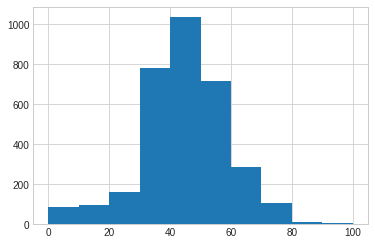

In [ ]:
# All individual county statistics
vaccination['Series_Complete_Pop_Pct'].hist()

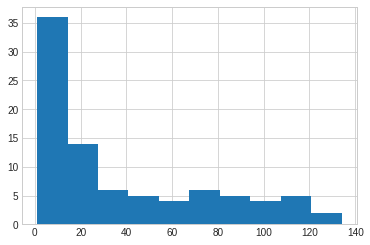

In [ ]:
def status_hist():
    return round((vaccination['Series_Complete_Pop_Pct']/10)*10).value_counts()

status_hist().hist()